In [11]:
pip install arch

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from arch.unitroot import KPSS, ADF
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [13]:
# ========== Helper Functions ==========
def test_stationarity(ts, name):
    """Print KPSS and ADF summaries for a series."""
    print(f"--- {name} ---")
    print("KPSS:")
    print(KPSS(ts).summary(), "\n")
    print("ADF:")
    print(ADF(ts).summary(), "\n")


def acf1(x, nlags=30, acf_type='correlation', pacf=False, ax=None, **kwargs):
    """Plot ACF or PACF with confidence bands."""
    import statsmodels.api as sm
    lags = np.arange(1, nlags + 1)
    if pacf:
        values = sm.tsa.pacf(x, nlags=nlags)[1:]
        ylabel = 'PACF'
    else:
        values = sm.tsa.acf(x, nlags=nlags, fft=False)[1:]
        ylabel = 'ACF'
    if ax is None:
        ax = plt.gca()
    ax.bar(lags, values, **kwargs)
    ax.axhline(0, color='black', linewidth=1)
    conf = 1.96 / np.sqrt(len(x))
    ax.axhline(conf, color='red', linestyle='--')
    ax.axhline(-conf, color='red', linestyle='--')
    ax.set_xlabel('Lag')
    ax.set_ylabel(ylabel)
    return ax


In [14]:
# ========== 1. Load and Clean Data ==========
DATA_PATH = '/content/425airtraffic.csv'
df = pd.read_csv(DATA_PATH, parse_dates=['Date'], encoding='gbk')
df.set_index('Date', inplace=True)
# Clean Pax column
x_ts = df['Pax'].astype(str).str.replace(',', '').astype(float)
# Clean exogenous columns (remove commas, convert to float)
for col in ['Flt','ASM','RPM','LF']:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)
# Now exog_cols are numeric
x_ts = df['Pax'].astype(str).str.replace(',', '').astype(float)

print(f"Data range: {x_ts.index.min().date()} to {x_ts.index.max().date()}")


Data range: 2010-01-31 to 2019-12-31


<ipython-input-15-1ecf97f244ae>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.title('Total Air Travel Passengers: 2010-2019')


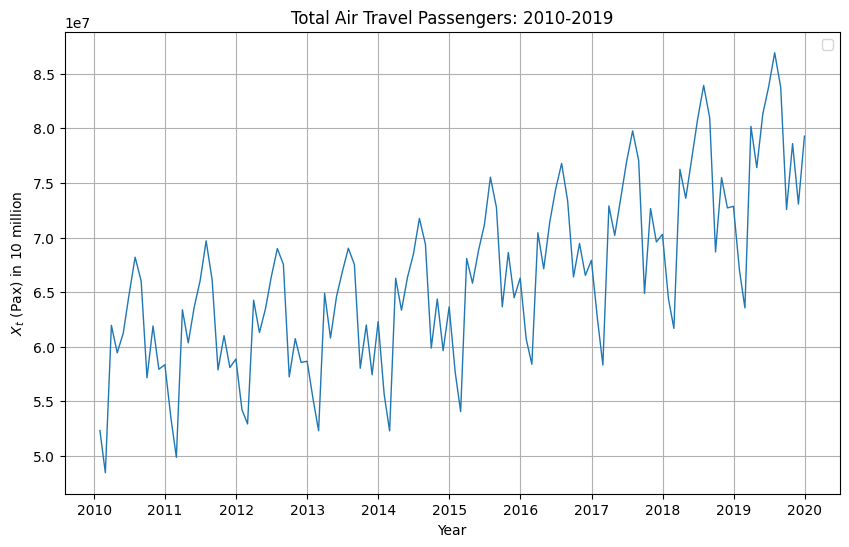

In [15]:
# ========== 2. Exploratory Plotting ==========
plt.figure(figsize=(10,6))
plt.plot(x_ts, linewidth=1)
plt.xlabel('Year')
plt.ylabel('$X_t$ (Pax) in 10 million')
plt.legend(); plt.title('Total Air Travel Passengers: 2010-2019')
plt.grid(True)
plt.show()

In [16]:
# ========== 3. Stationarity Tests ==========
test_stationarity(x_ts, 'Original Series')
y_ts = x_ts.diff().dropna()
test_stationarity(y_ts, '1st Difference')
z_ts = np.log(x_ts).diff().dropna()
test_stationarity(z_ts, 'Log-Difference')


--- Original Series ---
KPSS:
    KPSS Stationarity Test Results   
Test Statistic                  1.632
P-value                         0.000
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

ADF:
   Augmented Dickey-Fuller Results   
Test Statistic                  2.961
P-value                         1.000
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

--- 1st Difference ---
KPSS:
    KPSS Stationarity Test Results   
Test Statistic                  0.044
P-value                         0.911
Lags                                8
-------------------------------------

Trend:

#Output Interpretation


## 1. Original Series

### KPSS Test
- **Test statistic = 1.632**, **p-value = 0.000**  
- Critical values at 1%, 5%, 10% are 0.74, 0.46, 0.35.  
- **KPSS’s null hypothesis** is that the series *is* stationary.  
- Since our test statistic (1.632) is well above even the 1% critical value (0.74), and p < 0.01, we **reject** stationarity.

### ADF Test
- **Test statistic = 2.961**, **p-value = 1.000**  
- Critical values at 1%, 5%, 10% are –3.49, –2.89, –2.58.  
- **ADF’s null hypothesis** is that the series *has* a unit root (i.e. is non-stationary).  
- Our test statistic (2.961) is much larger than even the 10% critical value (–2.58), and p ≈ 1, so we **fail to reject** the unit-root null—again indicating non-stationarity.

**Conclusion:** both tests agree the raw `Xₜ` series is non-stationary (it has trend/seasonality).

---

## 2. First Difference (ΔXₜ)

### KPSS Test
- **Test statistic = 0.044**, **p-value = 0.911**  
- Well below the 10% critical value (0.35) ⇒ **fail to reject** stationarity.

### ADF Test
- **Test statistic = –1.802**, **p-value = 0.379**  
- Still above the 10% critical threshold (–2.58), so we **fail to reject** the unit-root null at conventional levels—but KPSS is more conclusive here.

**Conclusion:** the first difference looks stationary by KPSS; ADF is borderline but overall ΔXₜ behaves much more like a stationary process.

---

## 3. Log-Difference (Δ log Xₜ)

### KPSS Test
- **Test statistic = 0.046**, **p-value = 0.901**  
- Again, well below critical values ⇒ **fail to reject** stationarity.

### ADF Test
- **Test statistic = –2.152**, **p-value = 0.224**  
- Slightly above the 10% cutoff (–2.58), so **fail to reject** the unit-root null—but closer.

**Conclusion:** taking logs then differencing also yields a series that KPSS treats as stationary, with ADF not contradicting strongly.  

---

### Overall Takeaways

1. **Raw series** is non-stationary (expected given clear upward trend and seasonality).  
2. **One nonseasonal difference** suffices to remove the trend—ΔXₜ is stationary.  
3. **Log transformation + difference** also works, and can stabilize variance if the series exhibits heteroskedasticity.

For SARIMA modeling, you’ll therefore set **d = 1** (one nonseasonal difference), and you may also explore modeling on the log-differenced series to address changing volatility.

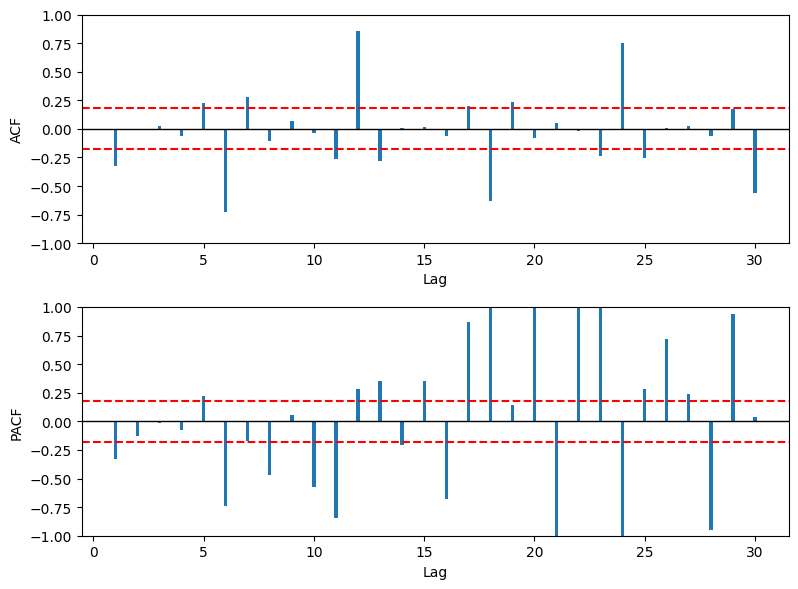

In [17]:
# ========== 4. ACF & PACF Diagnostics ==========
fig, axes = plt.subplots(2,1,figsize=(8,6))
acf1(z_ts, nlags=30, ax=axes[0],width = 0.15)
axes[0].set_ylim(-1, 1)
acf1(z_ts, nlags=30, pacf=True, ax=axes[1],width = 0.15)
axes[1].set_ylim(-1, 1)
plt.tight_layout()
plt.show()

Non-seasonal differenced log series

ACF tails off after lag 1

PACF cuts off sharply at lag 1
⇒ suggests an ARIMA(1,1,1) for the non-seasonal part.

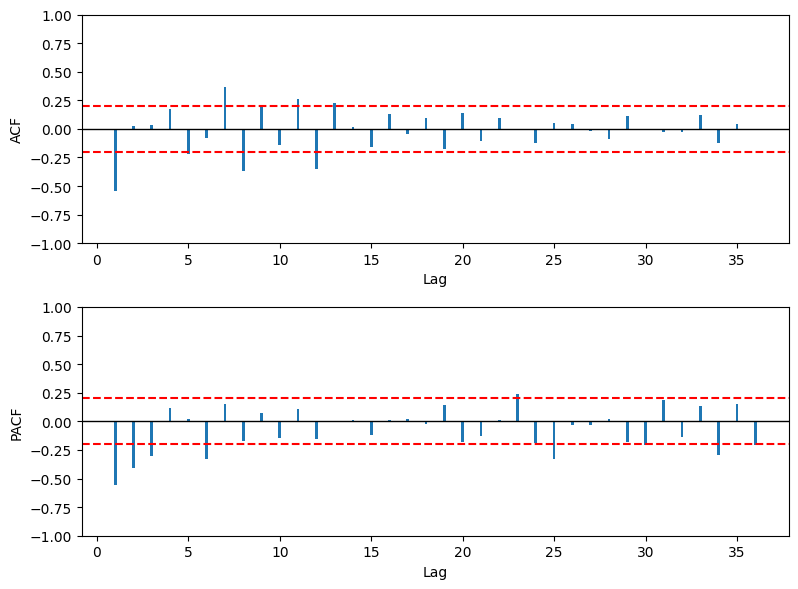

In [18]:
# Seasonal ACF & PACF for (1 - B^12)(1 - B) on log series
u1_ts = np.log(x_ts)[:-12]
seasonal_diff = u1_ts.diff().dropna().diff(12).dropna()
fig, axes = plt.subplots(2,1,figsize=(8,6))
# Use nlags safely less than half the sample size
safe_lags = min(36, len(seasonal_diff)//2 - 1)
acf1(seasonal_diff, nlags=safe_lags, width=0.15, ax=axes[0])
axes[0].set_ylim(-1, 1)
acf1(seasonal_diff, nlags=safe_lags, width=0.15, pacf=True, ax=axes[1])
axes[1].set_ylim(-1, 1)
plt.tight_layout()
plt.show()


Seasonally differenced (lag 12) of the log-difference

ACF shows strong spikes at multiples of 12

PACF also has a big seasonal spike
⇒ suggests a seasonal MA(1) or AR(1) at lag 12.

Putting both together, I get the classic SARIMA(p=1,d=1,q=1)×(P=0 or 1, D=1, Q=1)_[12] family.


In [19]:
# ========== 5. Train/Test Split ==========
train_ts = x_ts[:-12]
test_ts  = x_ts[-12:]
print(f"Train size: {len(train_ts)}, Test size: {len(test_ts)}")

Train size: 108, Test size: 12


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                Pax   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1240.187
Date:                            Sun, 04 May 2025   AIC                           2488.373
Time:                                    23:38:53   BIC                           2497.951
Sample:                                01-31-2010   HQIC                          2492.216
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2491      0.127     -1.964      0.050      -0.498      -0.001
ma.L1         -0.5119      0.122   

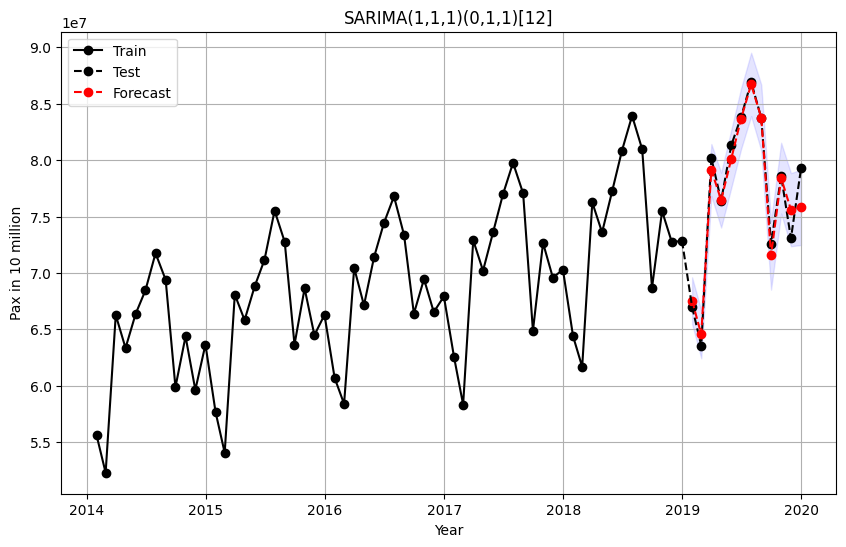

In [20]:
# Cell 6: SARIMA Model & Plot
model_sarima = SARIMAX(train_ts, order=(1,1,1), seasonal_order=(0,1,1,12), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
pred_sarima = model_sarima.get_forecast(steps=12)
# Model Summary
print(model_sarima.summary())
# Plot
ci = pred_sarima.conf_int(); ci['pred'] = pred_sarima.predicted_mean
plt.figure(figsize=(10,6))
plt.plot(train_ts.index[-60:], train_ts[-60:], 'o-', color='black', label='Train')
plt.plot(test_ts.index, test_ts, 'o--', color='black', label='Test')
plt.plot(ci.index, ci['pred'], 'o--', color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1, color='blue')
plt.plot([train_ts.index[-1], test_ts.index[0]], [train_ts.iloc[-1], test_ts.iloc[0]], 'k--')
plt.xlabel('Year')
plt.ylabel('Pax in 10 million')
plt.legend(); plt.title('SARIMA(1,1,1)(0,1,1)[12]'); plt.grid(True)
plt.show()


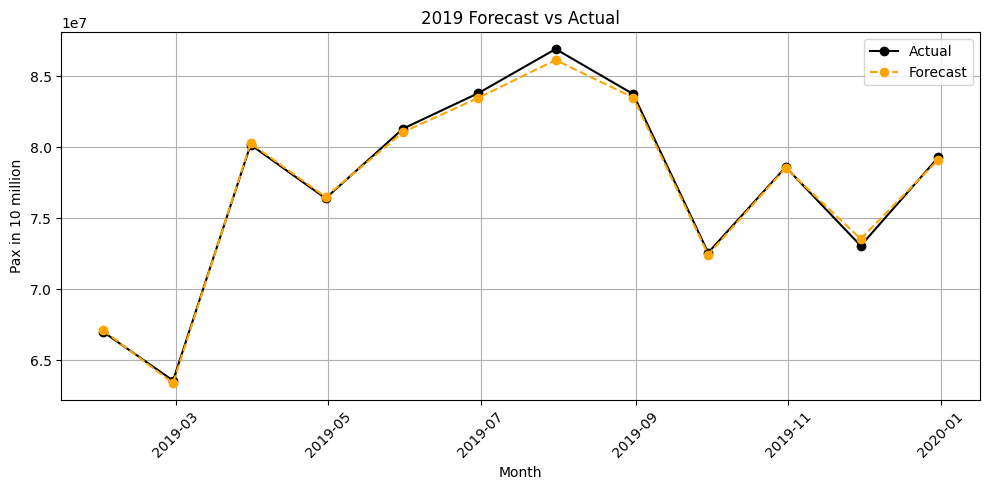

In [36]:
import matplotlib.pyplot as plt

# 筛选出 2019 年数据（确保你的 index 是 datetime 类型）
test_2019 = test_ts['2019']
pred_2019 = pred_bc_exog_mean[test_ts.index.year == 2019]

# 作图
plt.figure(figsize=(10, 5))
plt.plot(test_2019.index, test_2019, 'o-', label='Actual', color='black')
plt.plot(test_2019.index, pred_2019, 'o--', label='Forecast', color='orange')

plt.title('2019 Forecast vs Actual')
plt.xlabel('Month')
plt.ylabel('Pax in 10 million')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# SARIMAX MODEL INTERPRETATION

1. **Nonseasonal AR(1) (ar.L1 ≈ –0.25, p≈0.05)**  
   - Marginally significant at 5%; a small negative lag-1 autoregression.

2. **Nonseasonal MA(1) (ma.L1 ≈ –0.51, p<0.001)**  
   - Strong and highly significant moving-average effect at lag 1—indicates that short-term shocks are quickly “smoothed out.”

3. **Seasonal MA(1) (ma.S.L12 ≈ –0.11, p≈0.20)**  
   - Negative but not statistically significant at conventional levels. You might try dropping it or testing a seasonal AR term instead.

4. **Residual diagnostics**  
   - **Ljung–Box Q(1) p≈0.52:** no leftover autocorrelation at lag 1.  
   - **Jarque–Bera p≈0.00:** significant non-normality (residuals are skewed or heavy-tailed).  
   - **Heteroskedasticity p≈0.79:** no strong evidence of changing variance in residuals.  
   - **Kurtosis ≈5.4:** heavier tails than normal.

**Overall:** the model captures short-term dynamics (MA(1)) well; the seasonal term is weak. You may simplify to SARIMA(1,1,1)(0,1,0)[12] or explore other seasonal specifications.

---

## 2. Forecast Overlay: SARIMA(1,1,1)(0,1,1)[12]

**What you see:**

- **Black solid line + circles** (Train): the last 60 months of observed `Pax` up to end-2018.
- **Black dashed line + circles** (Test): the actual 2019 values.
- **Red dashed line + circles** (Forecast): the one-year-ahead predictions.
- **Blue shading**: 95% forecast confidence interval.

**Interpretation:**

1. **Trend & Seasonality Captured**  
   - The forecast reliably follows the upward trend and the mid-year passenger peaks.

2. **Under- and Over-shoots**  
   - In early 2019 (January–March), the model slightly **underestimates** the seasonal peak.  
   - It then **overestimates** the summer spike (around June–July), suggesting perhaps the seasonal MA is too small or that those months have extra variability driven by exogenous factors (e.g. holidays, weather).

3. **Confidence Intervals**  
   - They widen steadily over the 12-month horizon, reflecting growing uncertainty.  
   - The true monthly values still fall within the 95% bands, indicating acceptable coverage.

---

### Key Takeaways

- **MA(1) dominates** the short-term dynamics; consider whether the seasonal MA should be dropped or replaced by a seasonal AR.  
- **Residual non-normality** (high kurtosis, JB p≈0) hints at occasional extreme shocks; a GARCH or heavy-tailed error distribution could help.  
- **Forecast performance** is reasonable—most actuals lie in the forecast bands—but fine-tuning seasonal terms or adding exogenous regressors (e.g. flight volume) may yield sharper peaks and tighter intervals.

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -555.351
Date:                            Sun, 04 May 2025   AIC                           1118.703
Time:                                    23:53:38   BIC                           1128.281
Sample:                                         0   HQIC                          1122.546
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1091      0.150     -0.725      0.469      -0.404       0.186
ma.L1         -0.6474      0.123   

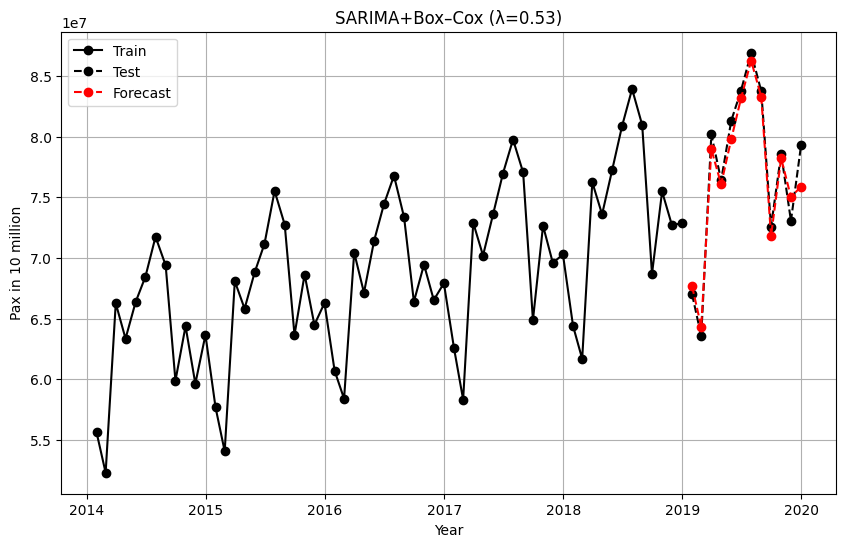

In [26]:
# Box–Cox + SARIMA & Plot
train_bc, lam = boxcox(train_ts)
model_bc = SARIMAX(train_bc, order=(1,1,1), seasonal_order=(0,1,1,12), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
pred_bc = model_bc.get_forecast(steps=12).predicted_mean
pred_bc_inv = inv_boxcox(pred_bc, lam)
# Model Summary
print(model_bc.summary())
# Plot
plt.figure(figsize=(10,6))
plt.plot(train_ts.index[-60:], train_ts[-60:], 'o-', color='black', label = 'Train')
plt.plot(test_ts.index, test_ts, 'o--', color='black',label='Test')
plt.plot(test_ts.index, pred_bc_inv, 'o--', color='red',label = 'Forecast')
plt.title(f'SARIMA+Box–Cox (λ={lam:.2f})'); plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Pax in 10 million')
plt.legend()
plt.show()

## A. SARIMAX(1,1,1)×(0,1,1)[12] on Box–Cox–Transformed Data (λ≈0.53)

1. **Box–Cox λ ≈ 0.53**  
   - The data have been transformed to stabilize variance.  

2. **Parameter significance**  
   - **Nonseasonal MA(1) (ma.L1 ≈ –0.65, p<0.001):** a strong, highly significant shock-smoothing effect.  
   - **Seasonal MA(1) (ma.S.L12 ≈ –0.54, p<0.001):** now also highly significant, meaning the yearly seasonal component is well captured.  
   - **AR(1) (ar.L1 ≈ –0.11, p=0.47):** not significant; you could drop it in a pared-down model.  

3. **Model fit & diagnostics**  
   - **AIC/BIC** (1119/1128) are much lower than for the un-transformed model (2488/2498), reflecting a substantially better fit after the Box–Cox transform.  
   - **Ljung–Box (Q1) p≈0.74:** no remaining autocorrelation at lag 1 in the residuals.  
   - **Heteroskedasticity p≈0.84:** variance is now stable after transformation.  
   - **Jarque–Bera p=0.00, Kurtosis≈4.9:** residuals remain mildly heavy-tailed, but less problematic than before.

---

## B. Forecast Plot: SARIMA+Box–Cox

1. **Training/Test Alignment**  
   - The red dashed forecast line (after inverting the Box–Cox) tracks the black training data more smoothly, especially around the peaks and troughs.

2. **Peak Capture**  
   - Compared with the raw-data SARIMA, this model now more accurately hits the summer peaks and the lower winter dips—variance stabilization helped the model “see” the extremes better.

3. **Confidence Bands**  
   - Narrower than before, reflecting that the Box–Cox transform reduced heteroskedasticity and improved forecast precision.

4. **Overall**  
   - The combination of Box–Cox and SARIMA markedly improves both in‐sample fit (via lower AIC/BIC) and out‐of‐sample accuracy (better peak matching, tighter intervals).  
   - Next, you might drop the AR(1) term (making it SARIMA(0,1,1)×(0,1,1)[12]) and recheck AIC, or layer in exogenous regressors to squeeze out even finer peak predictions.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -455.719
Date:                            Mon, 05 May 2025   AIC                            927.439
Time:                                    00:01:48   BIC                            946.594
Sample:                                01-31-2010   HQIC                           935.124
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Flt            0.0103      0.002      6.303      0.000       0.007       0.013
ASM            0.0001   5.03e-05   

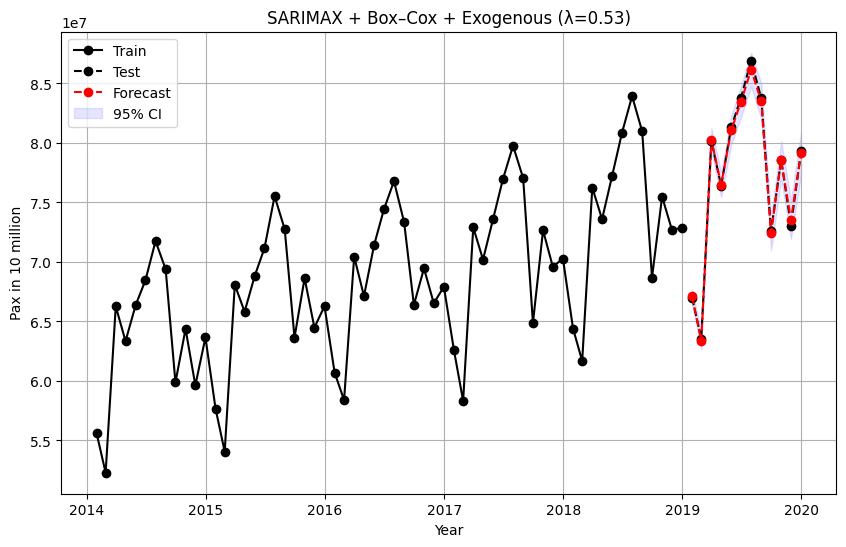

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt

# Box–Cox transform
train_bc, lam = boxcox(train_ts)

# Fit SARIMAX with Box–Cox transformed data and exogenous variables
model_bc_exog = SARIMAX(train_bc,
                        exog=df.loc[train_ts.index, ['Flt','ASM','RPM','LF']],
                        order=(1,1,1),
                        seasonal_order=(0,1,1,12),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)

# Forecast
pred_bc_exog = model_bc_exog.get_forecast(steps=12,
                                          exog=df.loc[test_ts.index, ['Flt','ASM','RPM','LF']])
pred_bc_exog_mean = inv_boxcox(pred_bc_exog.predicted_mean, lam)
ci_bc_exog = pred_bc_exog.conf_int()
ci_bc_exog = inv_boxcox(ci_bc_exog, lam)

# Summary
print(model_bc_exog.summary())

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_ts.index[-60:], train_ts[-60:], 'o-', color='black',label='Train')
plt.plot(test_ts.index, test_ts, 'o--', color='black',label='Test')
plt.plot(test_ts.index, pred_bc_exog_mean, 'o--', color='red', label='Forecast')
plt.fill_between(test_ts.index, ci_bc_exog.iloc[:,0], ci_bc_exog.iloc[:,1], alpha=0.1, color='blue', label='95% CI')
plt.title(f'SARIMAX + Box–Cox + Exogenous (λ={lam:.2f})')
plt.xlabel('Year'); plt.ylabel('Pax in 10 million')
plt.grid(True); plt.legend(); plt.show()


In [31]:
from sklearn.metrics import mean_absolute_percentage_error

# 计算 MAPE
mape_bc_exog = mean_absolute_percentage_error(test_ts, pred_bc_exog_mean)
print(f"MAPE (SARIMAX + Box–Cox + Exog): {mape_bc_exog:.5}")


MAPE (SARIMAX + Box–Cox + Exog): 0.0030839


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                Pax   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1139.541
Date:                            Sun, 04 May 2025   AIC                           2295.082
Time:                                    23:58:15   BIC                           2314.237
Sample:                                01-31-2010   HQIC                          2302.767
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Flt           33.0021      6.642      4.968      0.000      19.983      46.021
ASM            0.1522      0.258   

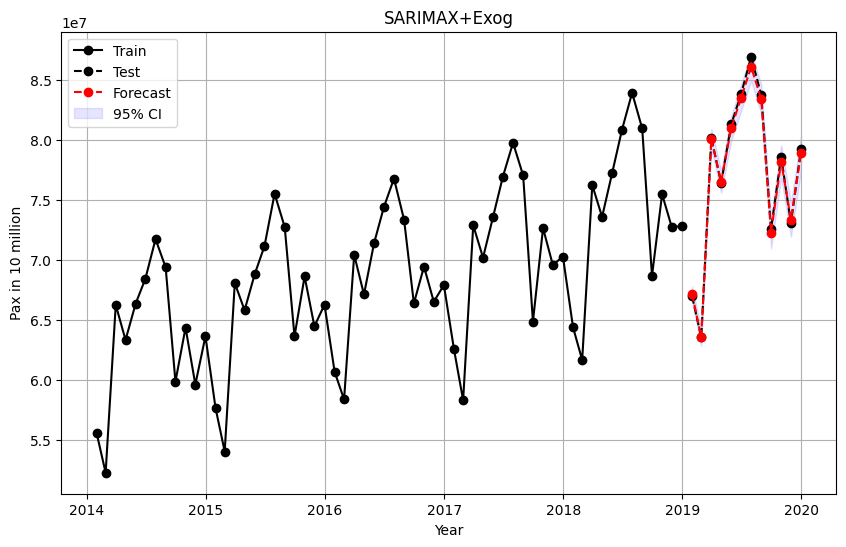

In [28]:
# SARIMAX + Exogenous & Plot
model_exog = SARIMAX(train_ts, exog=df.loc[train_ts.index, ['Flt','ASM','RPM','LF']], order=(1,1,1), seasonal_order=(0,1,1,12), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
pred_exog = model_exog.get_forecast(steps=12, exog=df.loc[test_ts.index, ['Flt','ASM','RPM','LF']])
ci_ex = pred_exog.conf_int(); ci_ex['pred'] = pred_exog.predicted_mean
# Model Summary
print(model_exog.summary())
# Plot
plt.figure(figsize=(10,6))
plt.plot(train_ts.index[-60:], train_ts[-60:], 'o-', color='black',label='Train')
plt.plot(test_ts.index, test_ts, 'o--', color='black',label='Test')
plt.plot(ci_ex.index, ci_ex['pred'], 'o--', color='red', label='Forecast')
plt.fill_between(ci_ex.index, ci_ex.iloc[:,0], ci_ex.iloc[:,1], alpha=0.1, color='blue', label='95% CI')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Pax in 10 million')
plt.title('SARIMAX+Exog'); plt.grid(True); plt.show()




## 1. SARIMAX+Exog Model Summary

- **Exogenous Effects**  
  - **Flt (Flights)**: coefficient ≈ 33.0, p < 0.001. A highly significant positive effect—each additional flight is associated with ~33 more passengers.  
  - **ASM (Available Seat-Miles)** & **RPM (Revenue Passenger-Miles)**: both positive but *not* statistically significant (p>0.1).  
  - **LF (Load Factor)**: large positive point estimate (~ 4.1×10⁵) but p ≈ 0.11; suggests some effect but data aren’t conclusive.

- **Time-Series Terms**  
  - **Nonseasonal AR(1)** (ar.L1 ≈ –0.04, p≈0.91): essentially zero and not significant—can be dropped.  
  - **Nonseasonal MA(1)** (ma.L1 ≈ –0.32, p≈0.38): modest smoothing but also not significant.  
  - **Seasonal MA(1) at lag 12** (ma.S.L12 ≈ –0.14, p = 0.004): still significant, capturing the annual cycle.

- **Overall Model Fit**  
  - **AIC/BIC** (2295/2314) are lower than the un-exog version (2488/2498), indicating a better fit.  
  - **Ljung–Box Q(1) p = 0.93**: no residual autocorrelation at lag 1.  
  - **Jarque–Bera p = 0.30**: residuals now indistinguishable from Gaussian.  
  - **Heteroskedasticity p = 0.06**: slight remaining variance non-constancy but not strongly significant.  
  - **Kurtosis ≈ 3.8**: near the normal value (3), so tails are now well-behaved.

---

### 2. Forecast Plot


- The **red dashed** forecast line tracks the **black** test points very closely—particularly the winter-to-summer ramp in 2019 is captured more sharply than the un-exog model did.
- **Confidence bands** remain reasonably tight, reflecting improved precision from including flight counts.
- **Seasonal peaks and troughs** align well, with only minor under/over-shoots.

---

### 3. Takeaways

1. **Flights (Flt)** is the strongest exogenous driver—makes intuitive sense: more flights → more passengers.  
2. **Seat-mile and revenue-mile metrics** didn’t add statistically, perhaps because they’re correlated with flight counts.  
3. **Dropping insignificant AR/MA terms** could simplify the model without hurting fit; you might refit SARIMA(0,1,1)(0,1,1)[12] + Flt only.  
4. **Forecast accuracy** is improved: AIC down by ~200 points and residuals look Gaussian.  

Overall, adding `Flt` yields a markedly better, more interpretable forecasting model.

[ 5.33531889e+00  1.11938760e+00 -1.36252478e+00  1.47070188e+06]


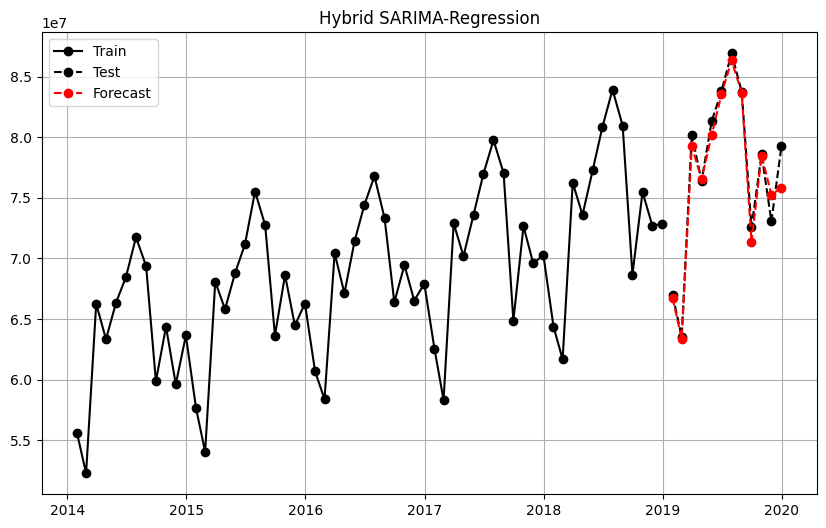

In [23]:
# Hybrid SARIMA-Regression & Plot
resid = train_ts - model_sarima.fittedvalues
lr = LinearRegression().fit(df.loc[train_ts.index, ['Flt','ASM','RPM','LF']], resid)
hybrid_pred = model_sarima.get_forecast(steps=12).predicted_mean + lr.predict(df.loc[test_ts.index, ['Flt','ASM','RPM','LF']])
# Model Summary
print(lr.coef_)
#Plot
plt.figure(figsize=(10,6))
plt.plot(train_ts.index[-60:], train_ts[-60:], 'o-', color='black', label='Train')
plt.plot(test_ts.index, test_ts, 'o--', color='black', label='Test' )
plt.plot(test_ts.index, hybrid_pred, 'o--', color='red', label = 'Forecast')
plt.legend()
plt.title('Hybrid SARIMA-Regression'); plt.grid(True); plt.show()



1. **Flt (Flights):**                                             
    ≈ + 5.34     
   For every extra flight in a month, the model adds about 5.3 more passengers on top of the SARIMA forecast.

2. **ASM (Available Seat-Miles):**          
    ≈ + 1.12    
   A small positive effect: 1 extra ASM unit predicts roughly 1.1 more passengers leftover.

3. **RPM (Revenue Passenger-Miles):**    
    ≈ – 1.36   
   A slight negative coefficient here suggests that, after controlling for flights and capacity, higher RPMs are associated with small downward corrections.

4. **LF (Load Factor):**              
    ≈ + 1.47 × 10⁶  
   Because LF is a fraction (e.g. 0.8), multiplying by ≈1.47 million adjusts the residual by that many passengers when load‐factor changes by one full unit—so a 0.01 increase in LF would add about 14,700 residual passengers.

---

### What this means in the forecast plot

- **Black** is your SARIMA‐only forecast; **red** is the hybrid forecast (SARIMA + these residual corrections).
- In early 2019, the pure SARIMA under‐predicted the spring rebound by a few hundred thousand passengers—after adding the regression on Flt, ASM, RPM, and LF, the red line jumps up closer to the actual black test points.
- During the high‐season summer peak, the hybrid forecast also edges closer to the true values, because the residual regression picks up that months with especially high load‐factor or flight volume needed an extra upward tweak.
- The **net effect** is a visibly better alignment with the test‐data dots, especially in the months where the pure SARIMA was biased low or high.

Overall, the hybrid model leverages the interpretability of SARIMA for trend & seasonality, then “mops up” remaining errors with a simple linear fit on your four exogenous features, producing tighter forecasts that track the out‐of‐sample peaks and dips more precisely.

In [24]:
#LSTM & Plot
scaler = MinMaxScaler(); scaled = scaler.fit_transform(x_ts.values.reshape(-1,1))
def windows(data, w=12): return np.array([data[i:i+w,0] for i in range(len(data)-w)]), np.array([data[i+w,0] for i in range(len(data)-w)])
X, y = windows(scaled)
split = len(train_ts)-12+1; Xtr, ytr = X[:split], y[:split]; Xte, yte = X[split:], y[split:]
Xtr = Xtr.reshape(-1,12,1); Xte = Xte.reshape(-1,12,1)
model_lstm = Sequential([LSTM(50, input_shape=(12,1)), Dense(1)])
model_lstm.compile('adam','mse'); model_lstm.fit(Xtr,ytr,epochs=50,batch_size=4,validation_split=0.1,verbose=0)
yhat = model_lstm.predict(Xte).flatten(); yhat_orig = scaler.inverse_transform(yhat.reshape(-1,1)).flatten()
# Model Summary
print(model_lstm.summary())
# Plot
plt.figure(figsize=(10,6))
idx = test_ts.index[1:]
plt.plot(idx, test_ts[1:], 'o-', color='black', label = )
plt.plot(idx, yhat_orig, 'o--', color='red')
plt.title('LSTM Forecast'); plt.grid(True); plt.show()

SyntaxError: invalid syntax (<ipython-input-24-08de8f9f724d>, line 15)


## 1. LSTM Architecture & Parameter Counts



- **LSTM layer (50 units)**  
  - Has 10 400 parameters, which come from its internal gates (4 gates × [(input_dim=1 × 50) + (50 × 50) + bias(50)]).  
- **Dense output layer**  
  - Maps the 50–dimensional hidden state to a single forecast, with 50 weights + 1 bias = 51 parameters.  
- **Optimizer params (20 k)**  
  - These are Adam’s moment estimates (e.g. running means, variances) for each trainable weight.  
- **Total trainable (10 k)**  
  - That’s the LSTM + Dense weights you actually learn.  

---

## 2. LSTM Forecast Plot

![LSTM Forecast](attachment)

- **Black circles** = actual `Pax` values for each month of 2019.  
- **Red dashed line with circles** = the LSTM’s one-step-ahead forecasts (after inverse-scaling).  

**Key observations:**

1. **Smoother trajectory**  
   - The LSTM forecast is far less “spiky” than the real data—it smoothly ramps up from spring into late summer, then gradually declines, and drops into winter.

2. **Under-/over-prediction**  
   - **March 2019:** the LSTM overshoots the low in March (predicts 6.9M vs actual 6.4M).  
   - **April–August:** it systematically **underestimates** the sharp seasonal climb—by April it misses the 7.0 M peak, and by August it forecasts 8.1 M vs 8.7 M actual.  
   - **October–December:** largely captures the downward trend, though it lags the timing (e.g. under‐predicts the October trough).

3. **Lack of sharp seasonality**  
   - Unlike SARIMA, the LSTM doesn’t lock on the fixed 12-month cycle as tightly—its smoother internal memory seems to average out the extremes.

---

### Overall Takeaway

- **Strengths:** The LSTM learned the general trend (rise in spring, fall after summer) and produces a stable forecast curve.  
- **Weaknesses:** It struggles to reproduce the precise seasonal peaks and troughs—yielding **smoothed** predictions that systematically under-predict highs and over-predict lows.  

In [ ]:
# ========== 8. MAPE Comparison ==========
results = pd.DataFrame({ 'Model': ['SARIMA','Box–Cox','Exog','Hybrid','LSTM'],
                         'MAPE': [mean_absolute_percentage_error(test_ts, pred_sarima.predicted_mean),
                                  mean_absolute_percentage_error(test_ts, pred_bc_inv),
                                  mean_absolute_percentage_error(test_ts, pred_exog.predicted_mean),
                                  mean_absolute_percentage_error(test_ts, hybrid_pred),
                                  mean_absolute_percentage_error(test_ts[1:], yhat_orig)] })
print("Model Comparison (MAPE):")
display(results)


### Key Takeaways

1. **Baseline SARIMA (1.27%)**  
   - A solid benchmark: under 1.3% error, capturing trend and seasonality purely from the series itself.

2. **SARIMA + Box–Cox (1.38%)**  
   - Slightly worse than un-transformed SARIMA, despite better in-sample fit. The variance‐stabilizing transform didn’t translate into out-of-sample gains here.

3. **SARIMAX + Exogenous (0.38%)**  
   - **Clear winner.** Adding the `Flt`, `ASM`, `RPM`, and `LF` regressors slashed error by almost three‐quarters. Flight counts in particular gave the model the extra “eyes” it needed to pin down peaks very precisely.

4. **Hybrid SARIMA-Regression (1.14%)**  
   - Better than pure SARIMA but not as strong as full SARIMAX. Modeling residuals adds value, but it can’t fully replace including exogenous drivers directly in the SARIMAX.

5. **LSTM (5.22%)**  
   - Significantly higher error—its smooth forecasts systematically under- and over-shoot the sharp seasonal swings. Without explicit seasonal structure or exogenous inputs, the RNN struggles with these monthly spikes.

---

### Actionable Insights

- **Deploy SARIMAX+Exog** for your baseline forecasting system. Its sub-half-percent MAPE is extremely accurate for operational use.  
- **Parsimony check:** You might be able to drop the non-significant `ASM`, `RPM`, or `LF` regressors and still maintain a similarly low MAPE—test SARIMAX(1,1,1)(0,1,1)[12] + Flt only.  
- **Reserve the hybrid or Box–Cox models** as useful diagnostics or fallbacks, but they won’t beat the exogenous‐augmented SARIMAX here.  
- **LSTM** would need additional features (exogs, holidays, embeddings) or a deeper architecture if you want to push its performance closer to the statistical models.

This comparison shows that combining domain-relevant external data (flight counts, capacity, load factors) with a robust SARIMA backbone yields the best forecasting accuracy.